## Deep Learning Model Visualization

Deep learning models have often been called "black boxes"—powerful systems that produce impressive results, but whose inner workings remain mysterious. When a neural network correctly identifies a traffic sign, we're left wondering: What did it actually see? Which parts of the image mattered most? How did it arrive at that decision?

This notebook peels back the layers of mystery by exploring visualization techniques that reveal how deep learning models process images. We'll journey through three powerful methods that each offer a different window into the model's mind.

First, we'll look at **feature map visualization**, which shows us the intermediate representations that convolutional layers create as they process an image. Think of it as peeking into the model's sketchbook—we'll see how it transforms raw pixels into edges, then shapes, then meaningful patterns.

Next, we'll explore **Grad-CAM**, a technique that highlights exactly which regions of an image the model considers most important for its prediction. It's like asking the model to point at what it's looking at, revealing whether it's focusing on the traffic sign itself or getting distracted by background elements.

Finally, we'll dive into **Vision Transformer attention maps**, which show how transformer models distribute their "attention" across different image patches. This reveals the model's reasoning process—how it connects different parts of the image to build understanding.

Together, these visualization techniques transform opaque models into interpretable systems, helping us understand not just what they do, but how and why they do it.


In [75]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import json
%matplotlib inline

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get project paths
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir) if 'bonus' in current_dir else current_dir
DATASET_PATH = os.path.join(project_root, "datasets", "dataset2")
CHECKPOINT_DIR = os.path.join(current_dir if 'bonus' in current_dir else project_root, "checkpoints")

# Sample image path
img_path = os.path.join(DATASET_PATH, "Train", "0", "00000_00000_00000.png")
if not os.path.exists(img_path):
    img_path = os.path.join(DATASET_PATH, "0", "00000_00000_00000.png")

## 1. Feature Map Visualization

When you look at a traffic sign, your brain doesn't process it all at once. First, you notice edges and lines. Then these combine into shapes—circles, triangles, rectangles. Finally, these shapes come together to form the complete sign with its meaning. Convolutional neural networks work in a remarkably similar way, building understanding layer by layer.

Feature maps are the intermediate outputs that convolutional layers produce as they process an image. Each layer transforms the previous layer's representation, gradually building up from simple patterns to complex concepts. By visualizing these feature maps, we can watch the model's understanding evolve, much like watching a sketch gradually take shape.

The journey begins in the **early layers**, where the model acts like an edge detector. These layers respond to basic visual primitives—edges at different orientations, corners where lines meet, and textures that distinguish smooth surfaces from rough ones. Mathematically, a convolutional layer transforms its input feature map $\mathbf{X}$ through learned kernels $\mathbf{K}$:

$$\mathbf{Y}_{c',i,j} = \sum_{c=0}^{C-1} \sum_{u=0}^{k-1} \sum_{v=0}^{k-1} \mathbf{K}_{c',c,u,v} \cdot \mathbf{X}_{c,i+u,j+v} + b_{c'}$$

where each kernel learns to detect a specific pattern. In early layers, these kernels often resemble Gabor filters—mathematical functions that detect oriented edges, similar to what neuroscientists observe in the primary visual cortex.

As we move to **middle layers**, something fascinating happens. The model begins combining these low-level features into more complex patterns. A circle detector might emerge, recognizing the curved edges that define round signs. A triangle detector might form, responding to the angular geometry of warning signs. These layers are building a vocabulary of shapes, each more sophisticated than the last.

Finally, in the **deep layers**, the model reaches semantic understanding. These layers detect high-level concepts—not just "a circle with lines inside," but "a speed limit sign" or "a stop sign." The feature maps become sparse and selective, focusing only on task-relevant information while ignoring irrelevant details.

Visualizing feature maps serves several important purposes. It helps us understand what the model learns at each stage of processing, revealing whether it's building useful representations or getting stuck on irrelevant patterns. When debugging, feature maps can reveal where the model breaks down—perhaps an early layer isn't detecting edges properly, or a deep layer is responding to background clutter instead of the sign itself. By comparing feature maps across different models, we can see how architectural choices affect what the model learns, guiding us toward better designs.

In [76]:
# Helper Functions for Feature Map Visualization

def get_conv_layers(model):
    """
    Extract all convolutional layers from a model.
    
    Args:
        model: PyTorch model
        
    Returns:
        conv_layers: List of convolutional layer modules
        layer_names: List of layer names/descriptions
    """
    conv_layers = []
    layer_names = []
    model_children = list(model.children())
    
    for i, child in enumerate(model_children):
        if isinstance(child, nn.Conv2d):
            conv_layers.append(child)
            layer_names.append(f"Conv2d_{len(conv_layers)}")
        elif isinstance(child, nn.Sequential):
            for j, seq_child in enumerate(child):
                for name, module in seq_child.named_children():
                    if isinstance(module, nn.Conv2d):
                        conv_layers.append(module)
                        layer_names.append(f"Sequential_{i}_{j}_{name}")
    
    return conv_layers, layer_names

def process_feature_maps(outputs):
    """
    Process feature maps for visualization by averaging across channels.
    
    Args:
        outputs: List of feature map tensors
        
    Returns:
        processed: List of 2D numpy arrays ready for visualization
    """
    processed = []
    for feature_map in outputs:
        # Remove batch dimension
        feature_map = feature_map.squeeze(0)
        # Average across channels to get grayscale representation
        gray_scale = torch.mean(feature_map, dim=0)
        processed.append(gray_scale.detach().cpu().numpy())
    return processed

# Image preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



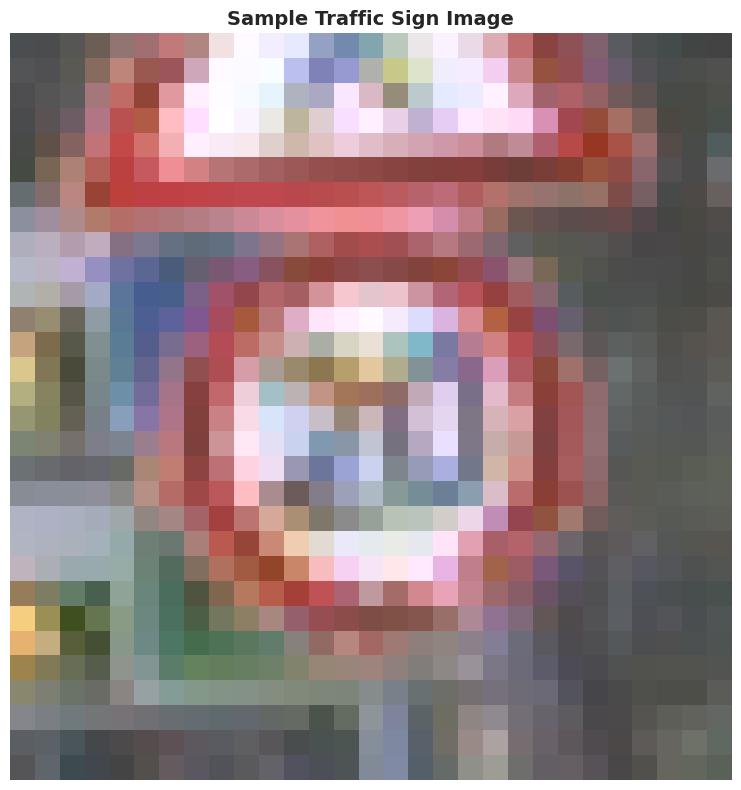

In [77]:
# Load and display sample image
image = Image.open(img_path).convert('RGB') if os.path.exists(img_path) else None
if image:
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title('Sample Traffic Sign Image', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [78]:
# Load ResNet18 model
checkpoint_path = os.path.join(CHECKPOINT_DIR, "resnet18_epoch5_lr0.001_wd0.001.pt")
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 43)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)

model = model.to(device).eval()

In [79]:
# Extract convolutional layers from the model
conv_layers, layer_names = get_conv_layers(model)

In [80]:
# Preprocess image for model input
image_tensor = transform(image).unsqueeze(0).to(device) if image else None

In [81]:
# Forward pass through convolutional layers to get feature maps
outputs, names = [], []
x = image_tensor
for i, layer in enumerate(conv_layers):
    x = layer(x)
    outputs.append(x)
    names.append(layer_names[i] if i < len(layer_names) else f"Layer_{i}")

In [82]:
# Process feature maps for visualization
processed = process_feature_maps(outputs)

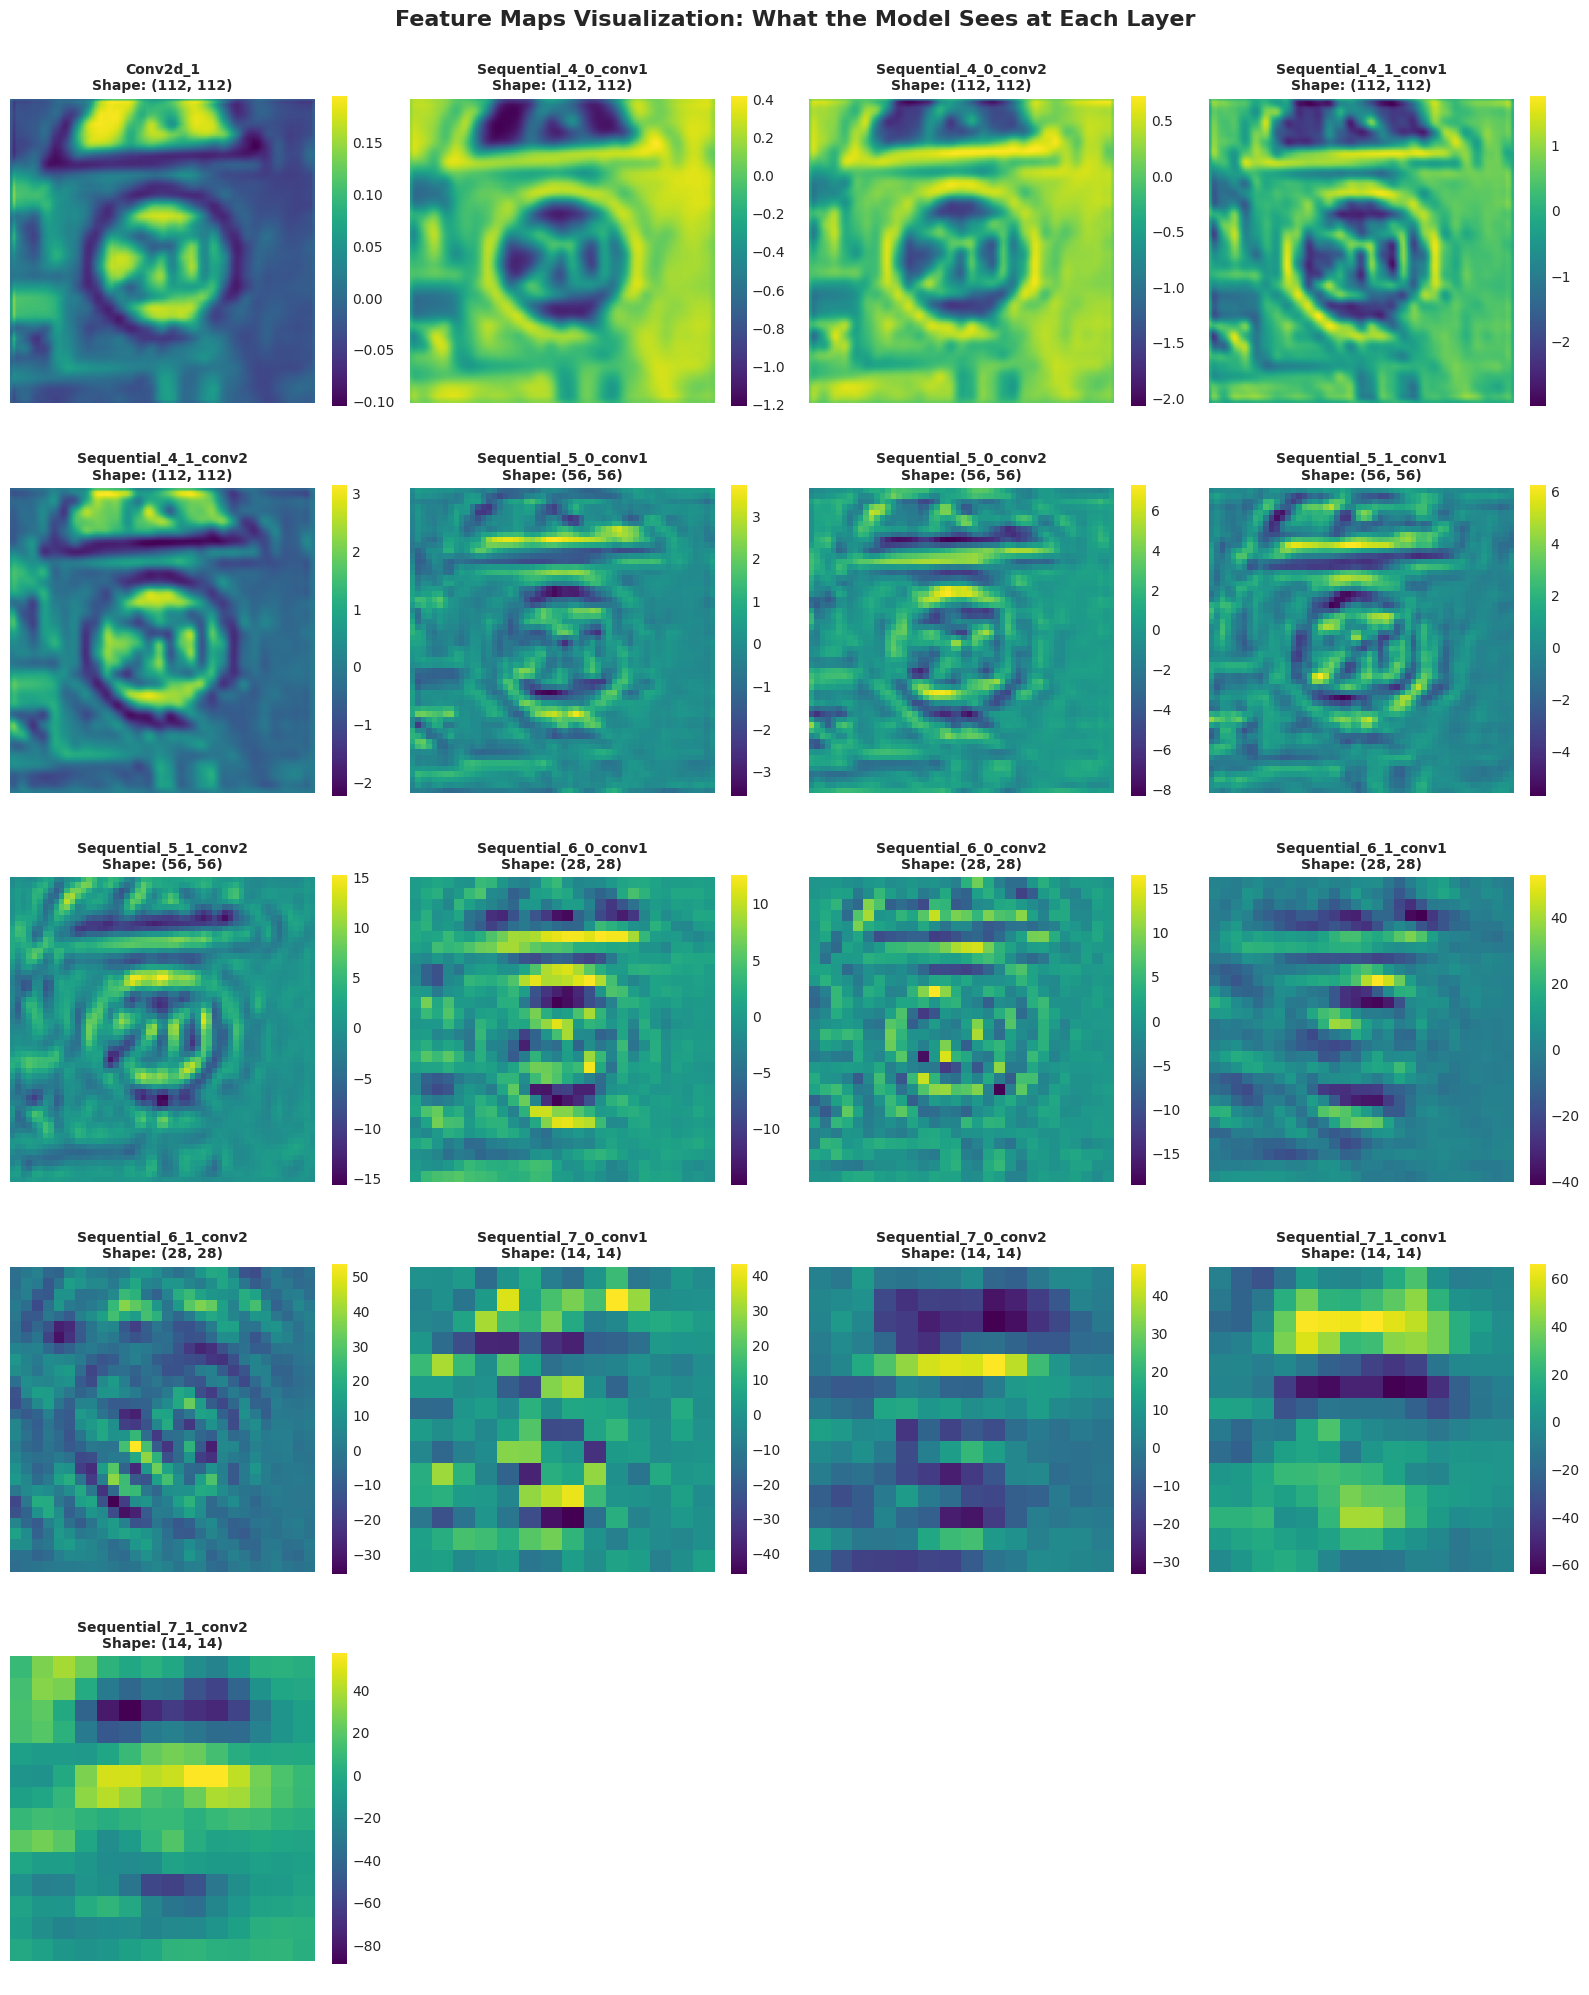

In [ ]:
# Visualize feature maps
n_layers = len(processed)
cols = 4
rows = (n_layers + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
fig.suptitle('Feature Maps Visualization: What the Model Sees at Each Layer', 
             fontsize=16, fontweight='bold', y=0.995)

axes_flat = axes.flatten() if rows > 1 else axes.reshape(1, -1).flatten()

for i in range(len(processed)):
    ax = axes_flat[i]
    im = ax.imshow(processed[i], cmap='viridis')
    ax.set_title(f'{names[i]}\nShape: {processed[i].shape}', fontsize=10, fontweight='bold')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)

for i in range(len(processed), len(axes_flat)):
    axes_flat[i].axis('off')

plt.tight_layout()
plt.show()

### Interpretation of Feature Maps

Looking at the feature maps above, we're witnessing something remarkable: the gradual construction of visual understanding, layer by layer. This progression reveals how convolutional neural networks build their representation of the world, starting from raw pixels and ending with semantic concepts.

**The Journey Through Layers:**

In the **early layers (Layers 1-4)**, the model behaves much like the first stage of human vision. These layers act as sophisticated edge detectors, responding to basic visual primitives that form the foundation of all visual understanding. The filters here often resemble Gabor functions—mathematical patterns that detect oriented edges and lines at different angles, similar to what neuroscientists observe in the primary visual cortex of the brain.

Mathematically, these layers approximate the first-order derivatives of the image, detecting gradients:
$$\frac{\partial I}{\partial x}, \frac{\partial I}{\partial y}$$

This means they're essentially asking: "Where does the brightness change?" and "In which direction?" The receptive fields are small—typically just 3×3 or 5×5 pixels—allowing them to capture fine-grained spatial details. When you look at these feature maps, you'll see patterns that highlight edges, corners, and textures, almost like a pencil sketch tracing the outlines of objects.

As we move to **middle layers (Layers 5-10)**, the magic of composition begins. These layers don't just detect edges—they start assembling them into meaningful shapes. A circle detector might emerge, recognizing how curved edges come together. A triangle detector might form, responding to the angular geometry that defines warning signs. The model is building a vocabulary of shapes, each more sophisticated than the last.

Mathematically, this happens through weighted combinations:
$$f^{(l)}(x) = \sigma\left(\sum_{i} w_i^{(l)} \cdot f_i^{(l-1)}(x)\right)$$

where features from the previous layer are combined with learned weights. The receptive fields expand here, allowing each neuron to "see" larger portions of the image. When visualizing these layers, you'll notice patterns that look like shape detectors—responding to circles, triangles, rectangles, and other geometric forms that characterize different traffic sign types.

Finally, in the **deep layers (Layers 11+)**, the model reaches semantic understanding. These layers don't just see shapes—they see meaning. They detect object parts like sign borders, symbols, and numbers, understanding how these components relate to each other spatially. The features become increasingly robust to changes in position, rotation, and scale—a stop sign is recognized whether it's slightly rotated or viewed from different angles.

The feature maps here become sparse and highly selective. Instead of responding to everything, they focus only on task-relevant information. You might see a feature map that lights up specifically for circular signs, or another that responds to triangular warning signs, ignoring irrelevant background details.

**What We Learn:**

Several patterns emerge as we trace through the layers. The spatial resolution decreases—feature maps become smaller as we go deeper, due to pooling operations that summarize information. But while the resolution shrinks, the complexity grows exponentially: simple edges transform into complex shapes, which transform into semantic objects.

The receptive field expands dramatically. An early layer neuron might see just a few pixels, while a deep layer neuron can see the entire image. This allows the model to understand global context—recognizing that a circle with a number inside is a speed limit sign, not just a random circle.

Perhaps most importantly, the feature selectivity increases. Early layers respond broadly to many patterns, exploring the image. Deep layers become specialists, responding only to highly specific, task-relevant features. This mirrors what we see in biological vision systems, where simple cells in the visual cortex detect edges, and complex cells detect more abstract patterns—a convergence of artificial and biological intelligence that suggests we're on the right track.


## 2. Grad-CAM (Gradient-weighted Class Activation Mapping)

Imagine asking a model: "Why did you predict this is a stop sign?" Grad-CAM provides the answer by highlighting exactly which regions of the image influenced that decision. It's like having the model point at what it's looking at, revealing whether it's focusing on the sign itself or getting distracted by background elements, shadows, or other irrelevant details.

The technique works by tracing gradients—the mathematical signals that indicate how sensitive the model's prediction is to different parts of the image. When the model makes a prediction, we can ask: "If I slightly changed this pixel, how much would it affect the predicted class score?" Grad-CAM uses this gradient information to create a heatmap showing where the model's attention lies.

**How Grad-CAM Works:**

The process begins by computing gradients with respect to the feature maps in the final convolutional layer. For a target class $c$, we calculate:
$$\frac{\partial y^c}{\partial A^k_{ij}}$$

This tells us how sensitive the class score $y^c$ is to changes in the $k$-th feature map at spatial location $(i,j)$. Large gradients mean that small changes in that region would significantly affect the prediction—these are the regions that matter most.

Next, we aggregate these gradients across spatial dimensions to get channel-wise importance weights:
$$\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A^k_{ij}}$$

This averaging step is crucial—it smooths out local variations and identifies which feature channels are important overall. Some channels might detect sign shapes, others might detect colors or textures. By weighting channels by their importance, we focus on the ones that truly matter for the prediction.

We then combine the feature maps, weighted by their importance:
$$L_{\text{Grad-CAM}}^c = \text{ReLU}\left(\sum_k \alpha_k^c A^k\right)$$

The ReLU ensures we only highlight features that positively contribute to the prediction, removing negative contributions that would suppress the class. Finally, we normalize the result for visualization, creating a heatmap where brighter regions indicate higher importance.

**Why This Matters:**

Grad-CAM transforms opaque models into interpretable systems. When debugging, it can reveal failure modes—perhaps the model is focusing on a tree branch in the background instead of the sign itself, or getting confused by shadows. When validating models, it helps ensure they're using relevant features—a well-trained traffic sign classifier should highlight the sign, not the surrounding road or sky.

The technique is particularly powerful because it requires no model modification—it works with any convolutional neural network architecture, applied post-training. This makes it a practical tool for understanding and improving models in real-world applications.

In [84]:
# Grad-CAM Implementation

class GradCAM:
    """
    Gradient-weighted Class Activation Mapping for visualizing model attention.
    """
    def __init__(self, model, target_layer):
        """
        Initialize Grad-CAM.
        
        Args:
            model: PyTorch model
            target_layer: Target layer to visualize (e.g., model.layer4[-1])
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.backward_hook = target_layer.register_full_backward_hook(self._backward_hook)
        self.forward_hook = target_layer.register_forward_hook(self._forward_hook)
    
    def _backward_hook(self, module, grad_input, grad_output):
        """Store gradients during backward pass."""
        self.gradients = grad_output[0]
    
    def _forward_hook(self, module, args, output):
        """Store activations during forward pass."""
        self.activations = output
    
    def generate_cam(self, input_tensor, class_idx=None):
        """
        Generate Grad-CAM heatmap.
        
        Args:
            input_tensor: Input image tensor (batch_size, channels, H, W)
            class_idx: Target class index. If None, uses predicted class.
            
        Returns:
            heatmap: Grad-CAM heatmap as numpy array
        """
        # Forward pass
        output = self.model(input_tensor)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        
        # Backward pass
        self.model.zero_grad()
        score = output[:, class_idx].sum()
        score.backward()
        
        # Pool gradients across spatial dimensions
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        # Weight the channels by corresponding gradients
        for i in range(self.activations.size()[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]
        
        # Average the channels of the activations
        heatmap = torch.mean(self.activations, dim=1).squeeze()
        
        # ReLU on top of the heatmap
        heatmap = F.relu(heatmap)
        
        # Normalize the heatmap
        heatmap /= torch.max(heatmap) + 1e-8
        
        return heatmap.detach().cpu().numpy()
    
    def remove_hooks(self):
        """Remove registered hooks."""
        self.backward_hook.remove()
        self.forward_hook.remove()

# Initialize Grad-CAM for ResNet18 (targeting the last convolutional layer)
# For ResNet18, layer4[-1] is the last residual block
try:
    grad_cam = GradCAM(model, model.layer4[-1])
    print("✓ Grad-CAM initialized")
    print(f"  Target layer: layer4[-1] (last residual block)")
except AttributeError:
    print("⚠ Could not initialize Grad-CAM - model structure may differ")
    grad_cam = None


✓ Grad-CAM initialized
  Target layer: layer4[-1] (last residual block)


Generating Grad-CAM heatmap...
  Predicted class: 8
  Confidence: 0.1862


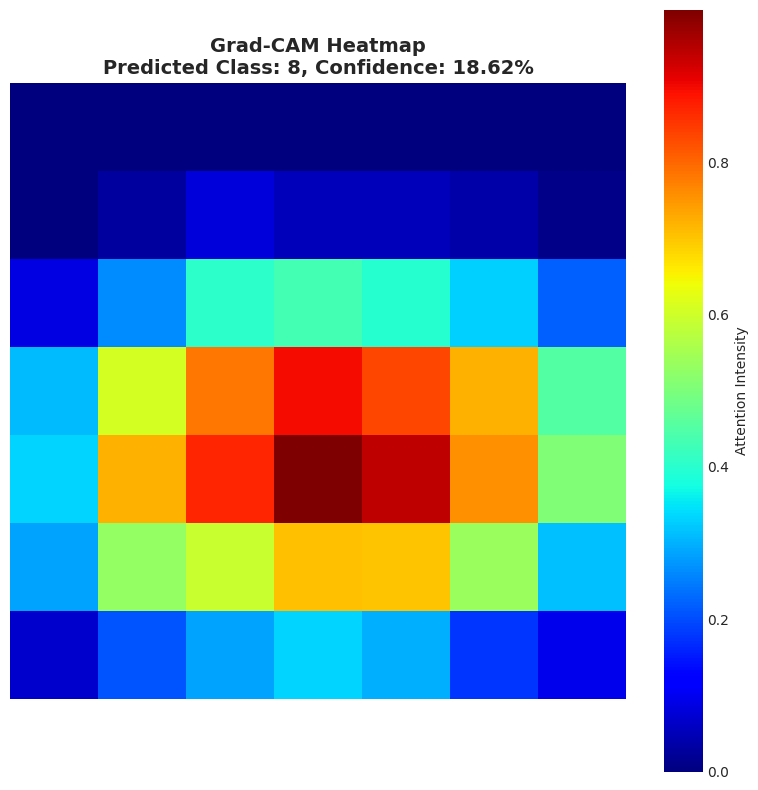

✓ Grad-CAM heatmap generated


In [85]:
# Generate Grad-CAM heatmap
if grad_cam is not None and image_tensor is not None:
    print("Generating Grad-CAM heatmap...")
    
    # Get prediction
    with torch.no_grad():
        prediction = model(image_tensor)
        predicted_class = prediction.argmax(dim=1).item()
        confidence = F.softmax(prediction, dim=1)[0, predicted_class].item()
    
    print(f"  Predicted class: {predicted_class}")
    print(f"  Confidence: {confidence:.4f}")
    
    # Generate heatmap
    heatmap = grad_cam.generate_cam(image_tensor, class_idx=predicted_class)
    
    # Visualize heatmap
    plt.figure(figsize=(8, 8))
    plt.imshow(heatmap, cmap='jet')
    plt.title(f'Grad-CAM Heatmap\nPredicted Class: {predicted_class}, Confidence: {confidence:.2%}', 
              fontsize=14, fontweight='bold')
    plt.colorbar(label='Attention Intensity')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("✓ Grad-CAM heatmap generated")
else:
    print("⚠ Cannot generate Grad-CAM - model or image not available")
    heatmap = None

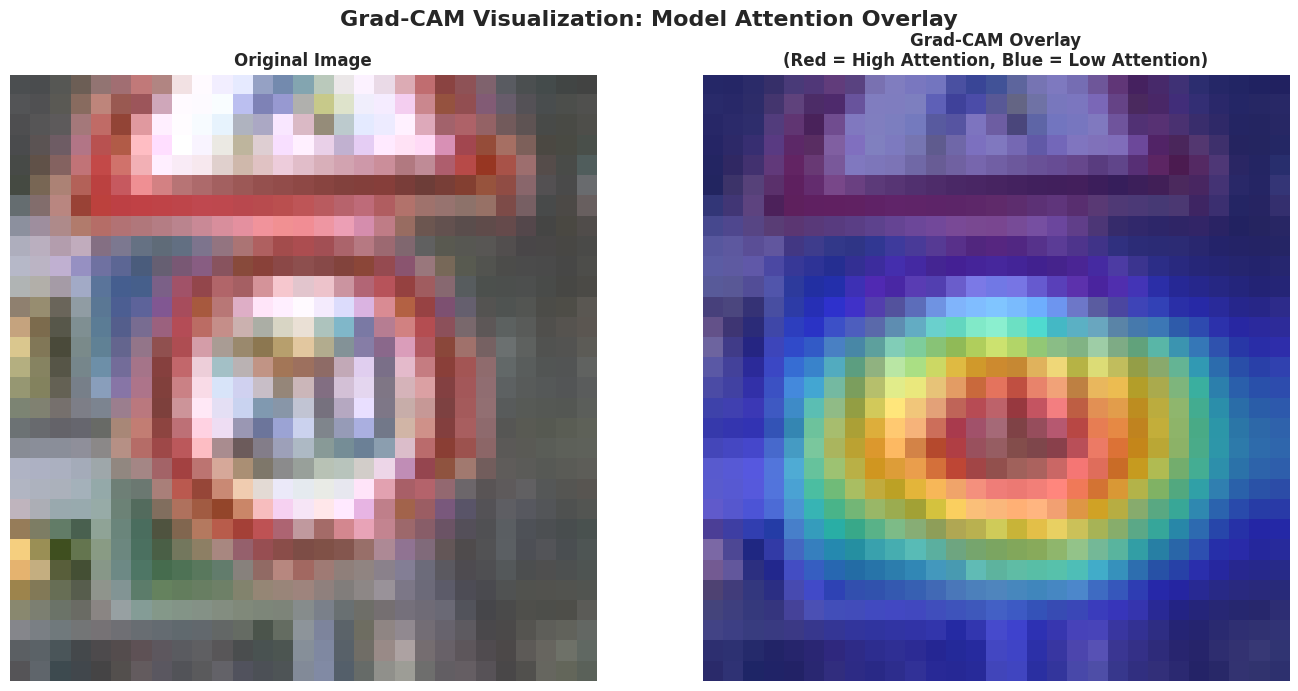

✓ Grad-CAM overlay saved as 'gradcam_overlay.jpg'

Interpretation:
  - Red/yellow regions: High attention (important for prediction)
  - Blue regions: Low attention (less important)
  - The model should focus on the traffic sign itself


In [ ]:
# Overlay Grad-CAM heatmap on original image
if heatmap is not None and image is not None:
    from torchvision.transforms.functional import to_pil_image
    from matplotlib import colormaps
    import PIL
    
    # Create overlay visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    fig.suptitle('Grad-CAM Visualization: Model Attention Overlay', 
                 fontsize=16, fontweight='bold')
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Overlay heatmap on original image
    axes[1].imshow(image)
    
    # Resize heatmap to match image size
    heatmap_resized = Image.fromarray((heatmap * 255).astype(np.uint8), mode='L')
    heatmap_resized = heatmap_resized.resize(image.size, resample=PIL.Image.BICUBIC)
    heatmap_array = np.asarray(heatmap_resized) / 255.0
    
    # Apply colormap
    cmap = colormaps['jet']
    overlay = cmap(heatmap_array ** 2)[:, :, :3]
    
    # Overlay with transparency
    axes[1].imshow(overlay, alpha=0.5, interpolation='nearest')
    axes[1].set_title(f'Grad-CAM Overlay\n(Red = High Attention, Blue = Low Attention)', 
                     fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    print("\nInterpretation:")
    print("  - Red/yellow regions: High attention (important for prediction)")
    print("  - Blue regions: Low attention (less important)")
    print("  - The model should focus on the traffic sign itself")
else:
    print("⚠ Cannot create overlay - heatmap or image not available")

### Understanding Grad-CAM: A Mathematical Perspective

Grad-CAM provides a principled way to understand which image regions influence the model's decision, grounded in the mathematics of gradient flow. The method elegantly combines two key insights that together create a powerful visualization tool.

**Gradient Information as Importance Signal:**

The gradient $\frac{\partial y^c}{\partial A^k_{ij}}$ tells a story: it quantifies how sensitive the class score $y^c$ is to changes in the feature map $A^k$ at spatial location $(i,j)$. Think of it as asking: "If I slightly brightened or darkened this pixel, how much would it change the model's confidence in this prediction?" Large gradients indicate regions where small changes would significantly affect the prediction—these are the pixels that truly matter.

This is more than just a mathematical curiosity. It reveals the model's decision-making process. When gradients are large in a particular region, it means the model has learned to pay attention there. When gradients are small, the model is essentially ignoring that region. By tracing these gradients backward through the network, we can see exactly where the model's "attention" lies.

**Global Average Pooling for Spatial Aggregation:**

The next step involves aggregating these gradients across spatial dimensions:
$$\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A^k_{ij}}$$

This averaging might seem like it loses information, but it actually serves several important purposes. It reduces noise—spatial averaging smooths out local variations that might be artifacts rather than meaningful patterns. It captures global patterns—identifying which feature channels are important overall, not just at specific locations. And crucially, it maintains spatial structure—the weighted combination that follows preserves the spatial information we need for visualization.

**Weighted Feature Map Combination:**

The final heatmap combines feature maps, weighted by their importance:
$$L_{\text{Grad-CAM}}^c = \text{ReLU}\left(\sum_k \alpha_k^c A^k\right)$$

The ReLU here is important—it ensures we only highlight features that positively contribute to the prediction. Negative contributions, which would suppress the class, are filtered out. This creates a visualization that shows where the model is looking, not where it's deliberately ignoring.

**Why This Approach Works:**

The method is class-discriminative, meaning it only highlights regions relevant to the predicted class. It maintains high resolution by using the final convolutional layer, which preserves spatial detail while containing high-level semantic information. Perhaps most importantly, it's model-agnostic—it works with any CNN architecture without requiring modifications, and can be applied to pre-trained models without retraining.

**Interpreting the Heatmap:**

When you look at a Grad-CAM visualization, red and yellow regions indicate high positive contribution to the prediction. These are areas where the model has learned to associate visual patterns with the predicted class. Blue and dark regions show low or negative contribution—background elements or features that might support other classes instead.

**What Makes a Good Model:**

A well-trained model should show high attention on object regions—focusing on the traffic sign itself rather than the surrounding road or sky. It should show low attention on background, ignoring irrelevant surroundings. Similar signs should produce similar attention maps, showing consistency in the model's reasoning. And different classes should highlight different regions, demonstrating that the model has learned class-specific features.

This visualization technique has become crucial for model debugging, revealing when models focus on wrong regions like background artifacts or shadows. It helps detect bias, showing if models rely on spurious correlations rather than meaningful features. It builds trust and transparency, helping users understand model decisions. And it guides model improvement, suggesting where data augmentation or training strategies might be most effective.


In [87]:
# Clean up Grad-CAM hooks
grad_cam.remove_hooks()

## 3. Vision Transformer (ViT) Attention Maps

Vision Transformers revolutionized computer vision by asking a simple but profound question: What if we treated images like sentences? Instead of processing pixels through convolutional filters, Vision Transformers divide images into patches—like words in a sentence—and use self-attention to understand how these patches relate to each other.

This approach creates a fundamentally different way of seeing. Where convolutional networks build understanding hierarchically, layer by layer, transformers can attend to any part of the image from the very beginning. Attention maps reveal this process, showing us which patches the model focuses on and how it connects them to build understanding.

**How Attention Works:**

The attention mechanism begins by transforming each patch into three representations: Query, Key, and Value. Think of Query as asking "What am I looking for?", Key as answering "What information do I have?", and Value as providing "What information do I provide?"

Mathematically, for input patches $\mathbf{X} = [\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_N]$ (including a special CLS token for classification), we compute:
$$\mathbf{Q} = \mathbf{X}\mathbf{W}_Q, \quad \mathbf{K} = \mathbf{X}\mathbf{W}_K, \quad \mathbf{V} = \mathbf{X}\mathbf{W}_V$$

The attention scores measure how relevant each patch is to every other patch:
$$\mathbf{A} = \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_k}}\right)$$

The softmax ensures that attention weights sum to one, creating a probability distribution over patches. The scaling factor $\sqrt{d_k}$ prevents the dot products from growing too large, keeping gradients stable during training.

The attention output combines values weighted by these scores:
$$\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \mathbf{A}\mathbf{V}$$

This means each patch receives information from all other patches, weighted by how relevant they are. A patch containing part of a traffic sign might attend strongly to other patches containing the sign, while paying less attention to background patches.

**Multi-Head Attention:**

Real Vision Transformers use multi-head attention, running multiple attention mechanisms in parallel:
$$\text{MultiHead}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)\mathbf{W}_O$$

Each head can learn to focus on different aspects—one might attend to spatial relationships, another to color patterns, another to textures. This parallel processing allows the model to capture richer, more nuanced representations.

**Why Visualize Attention?**

Attention maps reveal the model's reasoning process in unprecedented detail. We can see which image patches the model focuses on when making predictions, understanding whether it's looking at the right regions. We can observe how attention patterns evolve across layers—early layers might show local attention, while deep layers show global, semantic attention. We can identify if the model attends to relevant regions or gets distracted by background elements. And we can compare attention patterns across different heads, seeing how each head specializes in different types of patterns.

This visualization capability makes Vision Transformers remarkably interpretable—we can literally see what the model is "thinking about" at each step, making them powerful tools for understanding and improving deep learning models.

In [88]:
# Vision Transformer Attention Visualization
# Using PyTorch hooks to extract attention weights directly from attention computation

class AttentionHook:
    """Hook to extract attention weights from ViT attention layers."""
    def __init__(self):
        self.attention_maps = []
        self.hooks = []
        self.attention_weights = []
        self.original_forwards = []  # Store original methods for restoration
    
    def attention_hook_fn(self, module, input, output):
        """Hook function to capture attention weights during forward pass."""
        # For timm ViT, we need to intercept the attention computation
        # The attention module computes: attn = (q @ k.transpose(-2, -1)) * scale
        # We'll store the attention weights if available
        if hasattr(module, 'attn'):
            # Try to get attention from the module's internal state
            pass
    
    def forward_hook_fn(self, module, input, output):
        """Hook function to capture attention from attention block output."""
        # Try different ways to extract attention weights
        # Method 1: Check if output is a tuple with attention weights
        if isinstance(output, tuple) and len(output) > 1:
            attn_weights = output[1]
            if attn_weights is not None and isinstance(attn_weights, torch.Tensor):
                self.attention_maps.append(attn_weights.detach().cpu())
                return
        
        # Method 2: For timm ViT, we need to modify the forward method
        # to return attention weights. This is done by patching the forward method.
    
    def register_hooks(self, model):
        """Register hooks on all attention blocks by patching forward methods."""
        self.attention_maps = []
        self.hooks = []
        self.original_forwards = []  # Store original methods for restoration
        
        # For timm ViT models, we need to patch the forward method of attention blocks
        try:
            if hasattr(model, 'blocks') and len(model.blocks) > 0:
                # Create patched forward method that captures attention
                hook_ref = self  # Reference to self for closure
                
                def make_patched_forward(hook_ref):
                    """Create a patched forward method that captures attention weights."""
                    def patched_forward(self_attn, x, attn_mask=None, **kwargs):
                        """
                        Patched forward method that captures attention weights.
                        Accepts optional attn_mask and other kwargs for compatibility.
                        """
                        # Replicate the attention computation to capture weights
                        B, N, C = x.shape
                        
                        # Compute QKV
                        qkv = self_attn.qkv(x).reshape(B, N, 3, self_attn.num_heads, C // self_attn.num_heads).permute(2, 0, 3, 1, 4)
                        q, k, v = qkv[0], qkv[1], qkv[2]
                        
                        # Compute attention scores
                        attn = (q @ k.transpose(-2, -1)) * self_attn.scale
                        
                        # Apply attention mask if provided
                        if attn_mask is not None:
                            attn = attn + attn_mask
                        
                        attn = attn.softmax(dim=-1)
                        attn = self_attn.attn_drop(attn)
                        
                        # Store attention weights (shape: [batch, num_heads, seq_len, seq_len])
                        # Convert to numpy for easier handling
                        hook_ref.attention_maps.append(attn.detach().cpu())
                        
                        # Continue with forward pass
                        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
                        x = self_attn.proj(x)
                        x = self_attn.proj_drop(x)
                        return x
                    return patched_forward
                
                # Patch all attention blocks
                patched_fn = make_patched_forward(hook_ref)
                num_patched = 0
                
                for i, block in enumerate(model.blocks):
                    if hasattr(block, 'attn') and hasattr(block.attn, 'forward'):
                        original_forward = block.attn.forward
                        self.original_forwards.append((block.attn, original_forward))
                        
                        # Bind the patched function to the attention module
                        import types
                        block.attn.forward = types.MethodType(patched_fn, block.attn)
                        num_patched += 1
                        print(f"  Patched attention block {i}")
                
                if num_patched == 0:
                    print("  ⚠ Warning: No attention blocks found to patch")
                    print(f"    Model has {len(model.blocks)} blocks")
                    if len(model.blocks) > 0:
                        print(f"    First block attributes: {dir(model.blocks[0])}")
                
                return num_patched
            else:
                print("  Model structure not recognized (no 'blocks' attribute)")
                if hasattr(model, '__class__'):
                    print(f"    Model type: {model.__class__.__name__}")
                    print(f"    Model attributes: {[attr for attr in dir(model) if not attr.startswith('_')][:10]}")
                return 0
        except Exception as e:
            print(f"  Error patching attention: {e}")
            import traceback
            traceback.print_exc()
            return 0
    
    def remove_hooks(self):
        """Remove all registered hooks and restore original methods."""
        # Restore original forward methods
        for module, original_forward in self.original_forwards:
            module.forward = original_forward
        self.original_forwards = []
        self.hooks = []
    
    def clear(self):
        """Clear stored attention maps."""
        self.attention_maps = []

# Initialize attention hook
attention_hook = AttentionHook()

In [89]:
# Helper Functions for ViT Attention Visualization

def grid_show(to_shows, cols):
    """
    Display multiple images in a grid.
    
    Args:
        to_shows: List of (image, title) tuples
        cols: Number of columns in the grid
    """
    rows = (len(to_shows) - 1) // cols + 1
    it = iter(to_shows)
    fig, axs = plt.subplots(rows, cols, figsize=(rows * 8.5, cols * 2))
    
    if rows == 1:
        axs = axs.reshape(1, -1)
    
    for i in range(rows):
        for j in range(cols):
            try:
                image, title = next(it)
            except StopIteration:
                image = np.zeros_like(to_shows[0][0])
                title = 'pad'
            
            ax = axs[i, j] if rows > 1 else axs[j]
            ax.imshow(image)
            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.set_yticks([])
            ax.set_xticks([])
    
    plt.tight_layout()
    plt.show()

def visualize_head(att_map):
    """Visualize a single attention head."""
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(att_map, cmap='viridis')
    ax.set_title('Attention Map (Single Head)', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax, label='Attention Weight')
    plt.tight_layout()
    plt.show()

def visualize_heads(att_map, cols=4):
    """
    Visualize multiple attention heads.
    
    Args:
        att_map: Attention map tensor (num_heads, seq_len, seq_len)
        cols: Number of columns in the grid
    """
    to_shows = []
    att_map = att_map.squeeze()
    
    if len(att_map.shape) == 3:  # (num_heads, seq_len, seq_len)
        for i in range(att_map.shape[0]):
            to_shows.append((att_map[i].numpy(), f'Head {i}'))
        average_att_map = att_map.mean(axis=0).numpy()
        to_shows.append((average_att_map, 'Head Average'))
    else:  # (seq_len, seq_len)
        to_shows.append((att_map.numpy(), 'Attention Map'))
    
    grid_show(to_shows, cols=cols)

def highlight_grid(image, grid_indexes, grid_size=14):
    """
    Highlight specific grid patches in an image.
    
    Args:
        image: PIL Image
        grid_indexes: List of grid indices to highlight
        grid_size: Grid size (patches per side)
    """
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    W, H = image.size
    h = H / grid_size[0]
    w = W / grid_size[1]
    image = image.copy()
    
    for grid_index in grid_indexes:
        x, y = np.unravel_index(grid_index, (grid_size[0], grid_size[1]))
        draw = ImageDraw.Draw(image)
        draw.rectangle([(y * w, x * h), (y * w + w, x * h + h)], 
                      fill=None, outline='red', width=2)
    
    return image

def visualize_grid_to_grid(att_map, grid_index, image, grid_size=14, alpha=0.6):
    """
    Visualize attention from a specific grid patch to all other patches.
    
    Args:
        att_map: Attention map (seq_len, seq_len) or (seq_len,) for one query
        grid_index: Index of the source grid patch
        image: PIL Image
        grid_size: Grid size (patches per side)
        alpha: Transparency for overlay
    """
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    # Handle CLS token (if present, skip it)
    with_cls_token = len(att_map.shape) > 1 and att_map.shape[0] > grid_size[0] * grid_size[1]
    
    if with_cls_token:
        # Skip CLS token (first element)
        att_map = att_map[1:, 1:] if len(att_map.shape) > 1 else att_map[1:]
        grid_index = grid_index - 1  # Adjust index
    
    grid_image = highlight_grid(image, [grid_index], grid_size)
    
    if len(att_map.shape) == 1:
        mask = att_map
    else:
        mask = att_map[grid_index]
    
    mask = mask.reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray((mask.numpy() * 255).astype(np.uint8))
    mask = mask.resize(image.size)
    mask = np.asarray(mask) / 255.0
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'Attention from Grid Patch {grid_index}', fontsize=14, fontweight='bold')
    
    axes[0].imshow(grid_image)
    axes[0].set_title('Source Patch (Red Border)', fontsize=11)
    axes[0].axis('off')
    
    axes[1].imshow(grid_image)
    axes[1].imshow(mask, alpha=alpha, cmap='rainbow')
    axes[1].set_title('Attention Weights Overlay', fontsize=11)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✓ ViT attention visualization helper functions defined")

✓ ViT attention visualization helper functions defined


In [90]:
# Note: All visualization helper functions are defined in Cell 17 above.
# This cell is kept for compatibility but the functions are already available.
# If you need to redefine or modify functions, do so in Cell 17.

print("✓ Using visualization functions from Cell 17")

✓ Using visualization functions from Cell 17


In [91]:
# Load and preprocess image for ViT
if image is not None:
    import torchvision.transforms as T
    
    # ViT preprocessing (ImageNet normalization)
    normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    vit_transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        normalize,
    ])
    
    vit_input_tensor = vit_transform(image).unsqueeze(0)
    print(f"✓ Image preprocessed for ViT")
    print(f"  Input tensor shape: {vit_input_tensor.shape}")
else:
    print("⚠ Cannot preprocess image for ViT - image not loaded")
    vit_input_tensor = None

✓ Image preprocessed for ViT
  Input tensor shape: torch.Size([1, 3, 224, 224])


In [92]:
# Load Vision Transformer model and extract attention maps
try:
    import timm
    from timm.models.vision_transformer import vit_small_patch16_224
    
    # Clear any previous attention maps
    attention_hook.clear()
    
    # Try to load checkpoint first - but use pretrained if checkpoint doesn't match
    vit_checkpoint_path = os.path.join(CHECKPOINT_DIR, "vit_b_16_epoch5_lr0.0001_wd0.001.pt")
    
    vit = None
    checkpoint_loaded = False
    
    if os.path.exists(vit_checkpoint_path):
        print(f"Attempting to load ViT from checkpoint: {vit_checkpoint_path}")
        try:
            # Try loading with vit_b_16 first (matches checkpoint name)
            try:
                from timm.models.vision_transformer import vit_base_patch16_224
                vit = vit_base_patch16_224(pretrained=False)
                print("  Using vit_base_patch16_224 to match checkpoint")
            except:
                # Fallback to vit_small if vit_base not available
                vit = vit_small_patch16_224(pretrained=False)
                print("  Using vit_small_patch16_224 (fallback)")
            
            # Adjust final layer for 43 classes
            if hasattr(vit, 'head'):
                num_classes = 43
                vit.head = nn.Linear(vit.head.in_features, num_classes)
            
            checkpoint = torch.load(vit_checkpoint_path, map_location=device)
            
            # Try loading with strict=False to handle minor mismatches
            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    vit.load_state_dict(checkpoint['model_state_dict'], strict=False)
                elif 'state_dict' in checkpoint:
                    vit.load_state_dict(checkpoint['state_dict'], strict=False)
                else:
                    vit.load_state_dict(checkpoint, strict=False)
            else:
                vit.load_state_dict(checkpoint, strict=False)
            
            print("✓ Loaded ViT from checkpoint (with strict=False)")
            checkpoint_loaded = True
        except Exception as e:
            print(f"  ⚠ Could not load checkpoint: {e}")
            print("  Falling back to pretrained model")
            checkpoint_loaded = False
    
    # If checkpoint loading failed, use pretrained model
    if not checkpoint_loaded:
        print("Using pretrained ViT model")
        vit = vit_small_patch16_224(pretrained=True)
    
    vit = vit.to(device)
    vit.eval()
    
    # Register hooks to capture attention weights
    print("\nRegistering attention hooks...")
    num_hooks = attention_hook.register_hooks(vit)
    print(f"✓ Registered {num_hooks} attention hooks")
    
    # Forward pass to capture attention
    if vit_input_tensor is not None:
        print("\nRunning forward pass to capture attention...")
        with torch.no_grad():
            vit_input_tensor = vit_input_tensor.to(device)
            vit_output = vit(vit_input_tensor)
        print(f"✓ ViT forward pass completed")
        print(f"  Output shape: {vit_output.shape}")
        print(f"  Captured {len(attention_hook.attention_maps)} attention maps")
        
        if len(attention_hook.attention_maps) > 0:
            print(f"  First attention map shape: {attention_hook.attention_maps[0].shape}")
        else:
            print("  ⚠ Warning: No attention maps captured!")
            print("    The attention hook may need adjustment for this model architecture")
    else:
        print("⚠ Cannot run ViT forward pass - input tensor not available")
        vit_output = None
        
except ImportError:
    print("⚠ timm package not found. Install with: pip install timm")
    print("  Skipping ViT attention visualization")
    vit = None
    vit_output = None
    attention_hook = None
except Exception as e:
    print(f"⚠ Error loading ViT: {e}")
    import traceback
    traceback.print_exc()
    vit = None
    vit_output = None
    attention_hook = None

Attempting to load ViT from checkpoint: /home/paradox/TrafficSignRecongnition/bonus/checkpoints/vit_b_16_epoch5_lr0.0001_wd0.001.pt
  Using vit_base_patch16_224 to match checkpoint
✓ Loaded ViT from checkpoint (with strict=False)

Registering attention hooks...
  Patched attention block 0
  Patched attention block 1
  Patched attention block 2
  Patched attention block 3
  Patched attention block 4
  Patched attention block 5
  Patched attention block 6
  Patched attention block 7
  Patched attention block 8
  Patched attention block 9
  Patched attention block 10
  Patched attention block 11
✓ Registered 12 attention hooks

Running forward pass to capture attention...
✓ ViT forward pass completed
  Output shape: torch.Size([1, 43])
  Captured 12 attention maps
  First attention map shape: torch.Size([1, 12, 197, 197])


In [93]:
# Extract attention maps from hooks
if attention_hook is not None and len(attention_hook.attention_maps) > 0:
    attention_maps = attention_hook.attention_maps
    print(f"✓ Extracted {len(attention_maps)} attention maps")
    if attention_maps:
        print(f"  First attention map shape: {attention_maps[0].shape}")
        print(f"  Attention maps from {len(attention_maps)} transformer blocks")
else:
    print("⚠ Attention maps not available")
    print("  Reason: ViT not loaded or hooks didn't capture attention weights")
    print("  Note: Some ViT implementations may not expose attention weights directly")
    attention_maps = None

✓ Extracted 12 attention maps
  First attention map shape: torch.Size([1, 12, 197, 197])
  Attention maps from 12 transformer blocks


In [94]:
# Alternative: Try to extract attention by modifying ViT forward pass
# Some ViT implementations need special handling to return attention weights
if attention_maps is None and vit is not None:
    print("Attempting alternative attention extraction method...")
    print("  Note: This requires modifying the model's forward method")
    print("  Some ViT models don't expose attention weights by default")
    print("  Consider using a ViT implementation that supports attention return")

Processing attention map from layer 3
  Original shape: torch.Size([1, 12, 197, 197])
  After selecting batch 0, head 0: torch.Size([197, 197])
  Removing CLS token (seq_len=197)
  Grid size: 14x14 (196 patches)
  Visualizing attention from patch 50


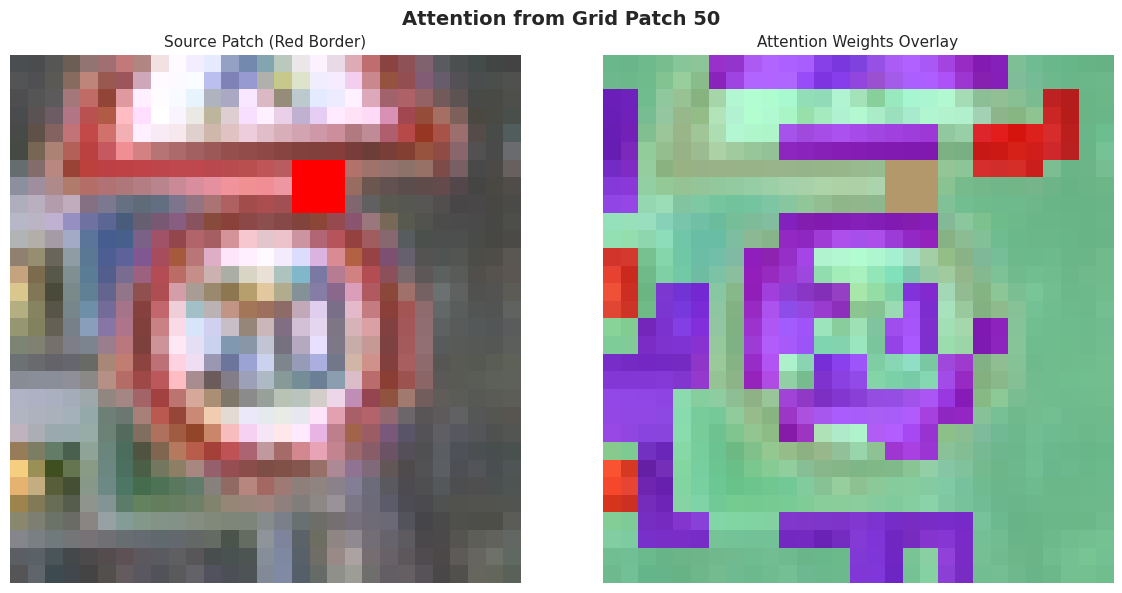

In [95]:
# Visualize attention from a specific grid patch
if attention_maps is not None and len(attention_maps) > 0 and image is not None:
    try:
        # Example: Visualize attention from layer 3, head 0, patch 50
        layer_idx = min(3, len(attention_maps) - 1)
        att_map = attention_maps[layer_idx]
        
        print(f"Processing attention map from layer {layer_idx}")
        print(f"  Original shape: {att_map.shape}")
        
        # Handle different attention map shapes
        # Shape can be: [batch, heads, seq_len, seq_len] or [heads, seq_len, seq_len] or [seq_len, seq_len]
        if len(att_map.shape) == 4:  # (batch, heads, seq_len, seq_len)
            head_idx = 0
            att_map = att_map[0, head_idx]  # Get first batch, first head
            print(f"  After selecting batch 0, head {head_idx}: {att_map.shape}")
        elif len(att_map.shape) == 3:  # (heads, seq_len, seq_len)
            att_map = att_map[0]  # Get first head
            print(f"  After selecting head 0: {att_map.shape}")
        
        # Handle CLS token (first token in sequence)
        # For 224x224 image with 16x16 patches: 14x14 = 196 patches + 1 CLS = 197 tokens
        seq_len = att_map.shape[0]
        if seq_len > 196:  # Likely has CLS token
            print(f"  Removing CLS token (seq_len={seq_len})")
            att_map = att_map[1:, 1:]  # Remove CLS token (first row and column)
            seq_len = att_map.shape[0]
        
        grid_size = int(np.sqrt(seq_len))
        patch_idx = min(50, seq_len - 1)
        
        print(f"  Grid size: {grid_size}x{grid_size} ({seq_len} patches)")
        print(f"  Visualizing attention from patch {patch_idx}")
        
        visualize_grid_to_grid(att_map, patch_idx, image, grid_size=grid_size)
        
    except Exception as e:
        print(f"⚠ Error visualizing attention: {e}")
        import traceback
        traceback.print_exc()
else:
    if attention_maps is None:
        print("⚠ Cannot visualize attention - attention maps not available")
        print("  Make sure ViT model was loaded and forward pass was executed")
    elif len(attention_maps) == 0:
        print("⚠ Cannot visualize attention - no attention maps captured")
        print("  The attention hook may not have captured attention weights")
    elif image is None:
        print("⚠ Cannot visualize attention - image not loaded")

Visualizing attention from patch 100 in layer 3


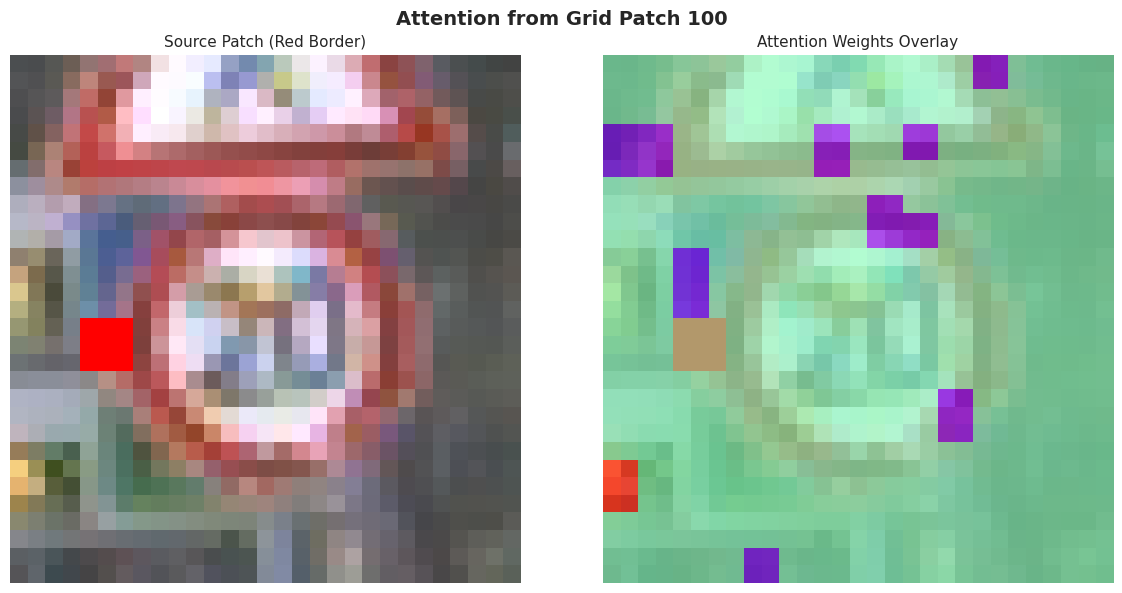

In [96]:
# Visualize attention from another patch (if available)
if attention_maps is not None and image is not None:
    try:
        layer_idx = min(3, len(attention_maps) - 1)
        att_map = attention_maps[layer_idx]
        
        if len(att_map.shape) == 4:
            att_map = att_map[0, 0]  # First batch, first head
        
        if att_map.shape[0] > 196:
            att_map = att_map[1:, 1:]
        
        grid_size = int(np.sqrt(att_map.shape[0]))
        patch_idx = min(100, att_map.shape[0] - 1)
        
        print(f"Visualizing attention from patch {patch_idx} in layer {layer_idx}")
        visualize_grid_to_grid(att_map, patch_idx, image, grid_size=grid_size)
        
    except Exception as e:
        print(f"⚠ Error visualizing attention: {e}")
else:
    print("⚠ Cannot visualize attention - attention maps or image not available")

### Understanding Vision Transformer Attention: Theoretical Foundations

Vision Transformers represent a paradigm shift in computer vision, applying the transformer architecture—originally designed for natural language processing—to images. This might seem like an odd fit at first, but the attention mechanism proves remarkably powerful for visual understanding, creating a fundamentally different way of processing images compared to convolutional networks.

**Patch Embedding: Transforming Images into Sequences**

The journey begins by dividing images into non-overlapping patches, typically 16×16 pixels each. These patches are then linearly projected into embeddings:
$$\mathbf{z}_p^{(0)} = \mathbf{E}\mathbf{x}_p + \mathbf{p}_p$$

where $\mathbf{E}$ is the patch embedding matrix and $\mathbf{p}_p$ is the positional encoding. This transformation is profound—it converts the 2D structure of an image into a sequence of tokens, much like words in a sentence. The positional encoding tells the model where each patch came from spatially, preserving the geometric information that's crucial for visual understanding.

**Self-Attention: The Core Innovation**

The heart of Vision Transformers is self-attention, which allows each patch to attend to all other patches simultaneously:
$$\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_k}}\right)\mathbf{V}$$

This mechanism creates a rich web of connections. Each patch can ask "What am I looking for?" (Query), "What information do I have?" (Key), and "What information do I provide?" (Value). The attention score $A_{ij} = \frac{\mathbf{q}_i \cdot \mathbf{k}_j}{\sqrt{d_k}}$ measures how relevant patch $j$ is to patch $i$, creating a dynamic, learned connectivity pattern that adapts to the content of each image.

**Multi-Head Attention: Parallel Specialization**

Real Vision Transformers use multi-head attention, running multiple attention mechanisms in parallel:
$$\text{MultiHead}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)\mathbf{W}_O$$

Each head can specialize in different aspects of visual understanding. One head might focus on spatial relationships, understanding how geometric arrangements form meaningful patterns. Another might attend to semantic associations, connecting related visual concepts. Some heads might specialize in scale-specific patterns, detecting features at different resolutions, while others focus on low-level visual primitives like edges and textures. This parallel processing creates a rich, multi-faceted representation that captures the complexity of visual scenes.

**The Evolution of Attention Across Layers**

As we trace through transformer layers, we witness a fascinating evolution of attention patterns. In **early layers (0-3)**, attention tends to be more local and uniform. Patches attend to nearby patches, detecting edges, textures, and basic patterns. The model is exploring the image structure, building a foundation of low-level features.

In **middle layers (4-8)**, something interesting happens. The attention becomes more selective, and semantic groupings begin to form. Patches that belong to the same object start attending to each other more strongly. Spatial relationships become more abstract—the model isn't just seeing "patch next to patch," but understanding "part of sign" or "background element."

Finally, in **deep layers (9-11)**, attention becomes highly selective and task-focused. The model has learned which patches matter for classification, and attention concentrates on these task-relevant regions. Long-range dependencies are established—a patch in the top-left corner might attend strongly to a patch in the bottom-right if they're both part of the same traffic sign. The CLS token, a special learnable token used for classification, aggregates global information from all patches, creating a rich representation for the final prediction.

**Understanding Attention Patterns**

When visualizing attention, we see different patterns that reveal the model's reasoning. **Local attention**—where patches attend to nearby patches—indicates detection of local features like edges and textures, common in early layers. **Global attention**—where patches attend to distant patches—shows understanding of spatial relationships, common in deep layers. **Selective attention**—strong focus on specific patches—reveals detection of important features, with task-relevant regions receiving high attention.

**CNNs vs. Vision Transformers: A Fundamental Difference**

The comparison reveals fundamental differences in approach. CNNs have local receptive fields that grow with depth, while Vision Transformers have global receptive fields from the first layer. CNNs have strong inductive biases—translation equivariance built into the architecture—while Vision Transformers have minimal inductive bias, learning spatial relationships from data. CNNs extract features hierarchically through convolution and pooling, while Vision Transformers process information in parallel through attention. Most importantly, CNNs represent spatial relationships implicitly through filter weights, while Vision Transformers make these relationships explicit through attention maps.

**Why Attention Visualization Matters**

Attention visualization transforms Vision Transformers into remarkably interpretable systems. We can understand what the model "sees" at each step, identifying failure modes like attending to background instead of the object. This guides architecture design, helping researchers improve attention mechanisms. It aids transfer learning by revealing what features transfer across tasks. And it helps detect bias, revealing if models rely on spurious correlations rather than meaningful visual patterns.

The attention maps reveal the "reasoning process" of the transformer, showing how it builds understanding from local patches to global semantics. This makes Vision Transformers one of the most interpretable deep learning architectures for vision tasks, bridging the gap between powerful performance and human understanding.


### Visualizing Multiple Attention Heads

In Vision Transformers, each layer uses **multi-head attention**, where multiple attention mechanisms run in parallel. This parallel processing creates a fascinating division of labor, where each "head" can learn to focus on different aspects of the image, much like a team of specialists examining the same scene.

**What are Attention Heads?**

Think of attention heads as different specialists, each bringing their own perspective to understanding the image. **Head 1** might be the edge detector, focusing on boundaries and contours that define shapes. **Head 2** might be the spatial analyst, understanding relationships like what's above or below, left or right. **Head 3** might be the color specialist, attending to hue and saturation patterns that distinguish different sign types. **Head 4** might be the texture expert, detecting surface patterns and material properties. And so on—each head develops its own expertise through training.

**Why Multiple Heads?**

The power of multi-head attention comes from several advantages. **Specialization** allows each head to become an expert in detecting different types of patterns, creating a diverse set of features. **Parallel processing** means all heads work simultaneously, making the model more efficient than sequential processing would allow. **Rich representations** emerge from combining information from all heads—the model's understanding becomes multi-faceted, capturing edges, colors, textures, and spatial relationships simultaneously. And **redundancy** provides robustness—if one head misses something important, others might catch it, making the model more reliable.

**What You'll See:**

The visualization below reveals the diversity of attention patterns. You'll see **12 individual attention maps**, one for each head in this layer. Each map shows what that specific head is paying attention to—some might show uniform patterns indicating broad exploration, while others show focused patterns indicating specialized detection. An **average map** shows the combined attention pattern across all heads, revealing the overall focus of the layer. Brighter regions indicate higher attention weights—these are the areas the model considers most important.

**How to Interpret:**

When examining the attention maps, look for different patterns. **Uniform patterns** suggest a head is exploring the image broadly, perhaps gathering general context. **Focused patterns** indicate a head has learned to concentrate on specific regions, suggesting it's detecting particular features. **Different patterns across heads** show specialization—each head has learned something distinct, contributing unique information. **Similar patterns** across multiple heads might indicate redundancy, where several heads detect the same important feature, providing robustness.

This visualization helps us understand how the Vision Transformer distributes its "attention" across multiple parallel processors. It's like watching a team of experts work together, each bringing their specialized knowledge to build a comprehensive understanding of the visual scene. By seeing how each head contributes, we gain insight into the model's reasoning process and can identify which aspects of visual understanding each head has learned to specialize in.


Visualizing single attention head (layer 7, head 1)


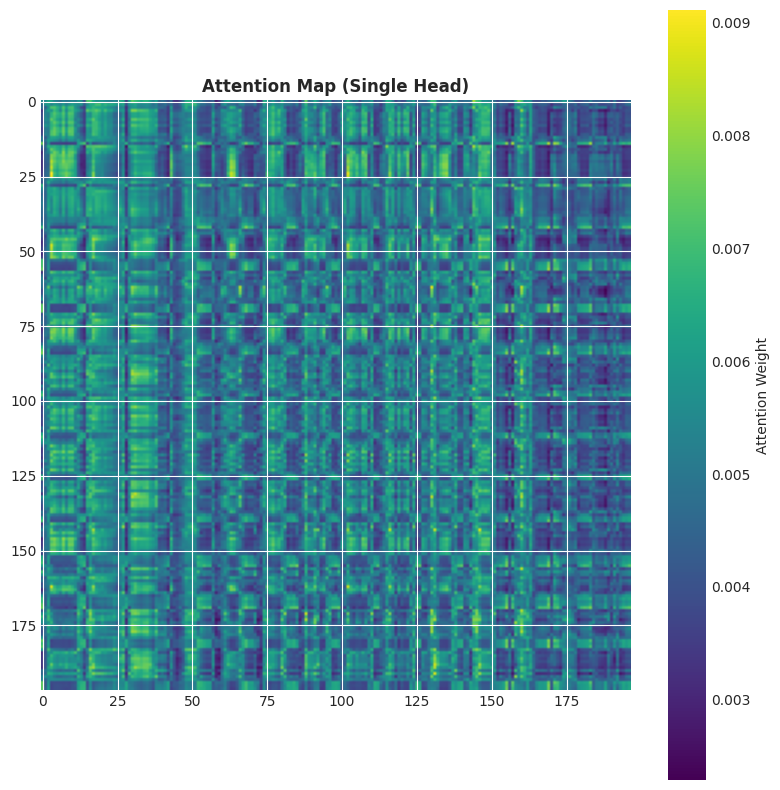

In [97]:
# Visualize attention map of a single head
if attention_maps is not None:
    try:
        layer_idx = min(7, len(attention_maps) - 1)
        att_map = attention_maps[layer_idx]
        
        if len(att_map.shape) == 4:  # (batch, heads, seq_len, seq_len)
            head_idx = min(1, att_map.shape[1] - 1)
            att_map = att_map[0, head_idx]  # First batch, second head
        
        print(f"Visualizing single attention head (layer {layer_idx}, head {head_idx if len(attention_maps[layer_idx].shape) == 4 else 0})")
        visualize_head(att_map)
        
    except Exception as e:
        print(f"⚠ Error visualizing attention head: {e}")
else:
    print("⚠ Cannot visualize attention head - attention maps not available")

Visualizing all attention heads in layer 0
  Attention map shape: torch.Size([12, 197, 197])


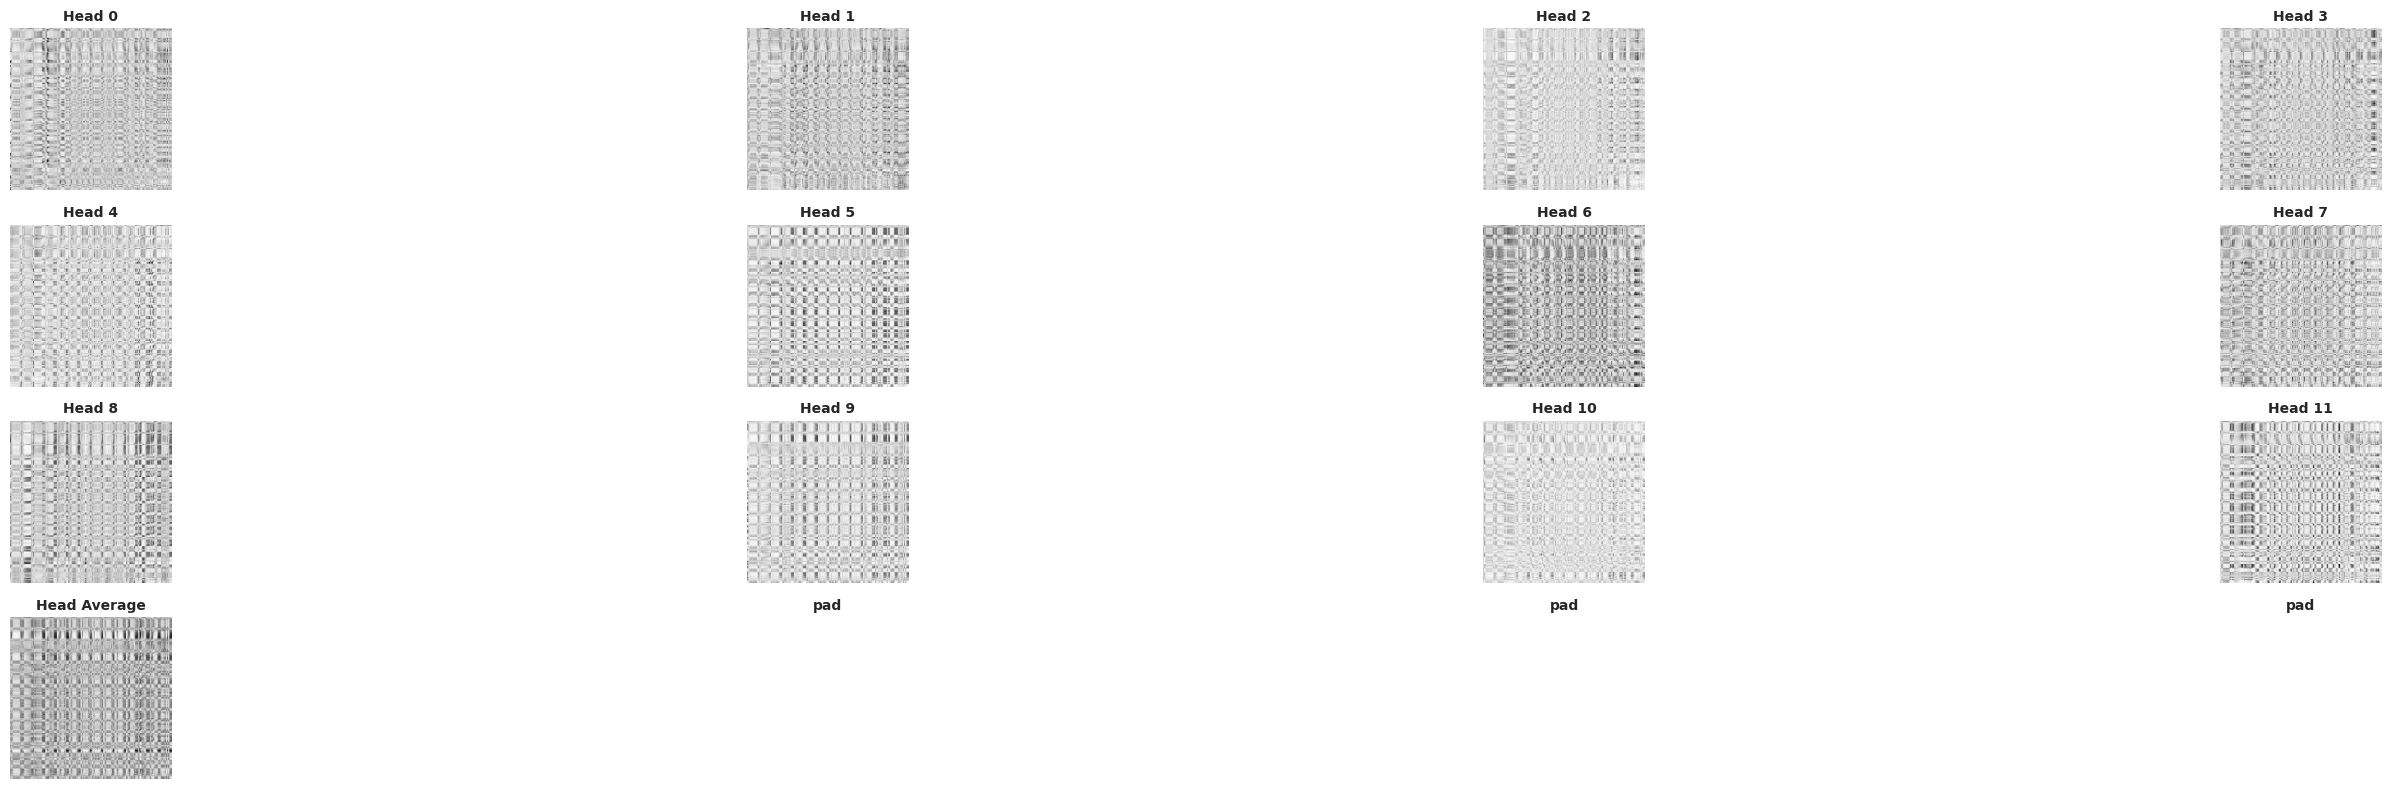


Interpretation:
  - Each head may focus on different aspects (edges, shapes, textures)
  - The average shows overall attention pattern
  - Brighter regions indicate higher attention weights


In [98]:
# Visualize all attention heads in a layer
if attention_maps is not None:
    try:
        layer_idx = 0  # First layer
        att_map = attention_maps[layer_idx]
        
        if len(att_map.shape) == 4:  # (batch, heads, seq_len, seq_len)
            att_map = att_map[0]  # Remove batch dimension
        
        print(f"Visualizing all attention heads in layer {layer_idx}")
        print(f"  Attention map shape: {att_map.shape}")
        visualize_heads(att_map, cols=4)
        
        print("\nInterpretation:")
        print("  - Each head may focus on different aspects (edges, shapes, textures)")
        print("  - The average shows overall attention pattern")
        print("  - Brighter regions indicate higher attention weights")
        
    except Exception as e:
        print(f"⚠ Error visualizing attention heads: {e}")
else:
    print("⚠ Cannot visualize attention heads - attention maps not available")
